# Proyecto Final de Deep Learning: Desenvolviendo el Sonido en la Universidad del Valle de Guatemala

> Este trabajo se basa en distintos proyectos de separación de audio, como por ejemplo el proyecto [Music Source Separation](https://github.com/andabi/music-source-separation) desarrollado durante el [Jeju Machine Learning Camp 2017](http://mlcampjeju.kakao.com). Sin embargo, han servido como base y han sido extensamente modificados y mejorados como parte del proyecto final para la Universidad del Valle de Guatemala por Ale Gómez, Michy Solano, Andrea Lam, Chris García, Gabo Vicente y Rodri Barrera.

## Introducción 🎵

La separación de fuentes musicales es una tarea esencial en el procesamiento de señales de audio, que se centra en separar diferentes componentes de una canción, como la voz y los instrumentos. Este proyecto busca mejorar la arquitectura y la eficacia del modelo inicial propuesto en el repositorio base, explorando técnicas avanzadas en redes neuronales y procesamiento de señales.


### Comparativas con Herramientas Existentes:

- Comparación de rendimiento con herramientas existentes como Splitter AI, validando las mejoras implementadas y proporcionando un benchmark sobre el estado del arte.

## Evaluación y Métricas 📊

- Utilización de métricas estándar en la tarea de separación de fuentes como SDR, SIR y SAR, además de otras métricas relevantes como la precisión y la recall en la detección de componentes vocales e instrumentales.
- Documentación meticulosa de los resultados obtenidos, incluyendo visualizaciones de espectrogramas y comparativas cualitativas.




## Referencias 📚

1. Zhe-Cheng Fan, Tak-Shing T. Chan, Yi-Hsuan Yang, and Jyh-Shing R. Jang, "[Music Signal Processing Using Vector Product
Neural Networks](http://mac.citi.sinica.edu.tw/~yang/pub/fan17dlm.pdf)", Proc. of the First Int. Workshop on Deep Learning and Music joint with IJCNN, May, 2017
2. P.-S. Huang, M. Kim, M. Hasegawa-Johnson, P. Smaragdis, "[Joint Optimization of Masks and Deep Recurrent Neural Networks for Monaural Source Separation](http://paris.cs.illinois.edu/pubs/huang-ismir2014.pdf)", IEEE/ACM Transactions on Audio, Speech, and Language Processing, vol. 23, no. 12, pp. 2136–2147, Dec. 2015
3. P.-S. Huang, M. Kim, M. Hasegawa-Johnson, P. Smaragdis, "[Singing-Voice Separation From Monaural Recordings Using Deep Recurrent Neural Networks](https://posenhuang.github.io/papers/DRNN_ISMIR2014.pdf)" in International Society for Music Information Retrieval Conference (ISMIR) 2014.
4. Tohru Nitta, "[A backpropagation algorithm for neural networks based an 3D vector product. In Proc. IJCNN](https://staff.aist.go.jp/tohru-nitta/IJCNN93-VP.pdf)", Proc. of IJCAI, 2007.

### Base del modelo:

- 3 capas RNN
- 2 capas Dense

----------


Instrucciones de uso:

Agregar paths correctamente en la sección de "Configuración"
Correr el notebook

## Comprensión del Audio y su Importancia en el Modelo

El audio es una señal temporal que contiene información sobre las frecuencias que lo componen. Para que un modelo de Deep Learning pueda procesar y entender estas señales, es crucial transformarlas de su forma temporal a una representación que destaque sus características distintivas. Aquí es donde los espectrogramas juegan un papel fundamental.

### Espectrogramas: Visualización de la Información de Frecuencia

Los espectrogramas son representaciones bidimensionales del espectro de frecuencias de una señal de audio a lo largo del tiempo. Permiten visualizar cómo varían las intensidades de las distintas frecuencias, lo que es esencial para identificar y separar las fuentes de sonido en una grabación musical.

#### ¿Por qué son importantes los espectrogramas?

1. **Descomposición de Frecuencias**: Los espectrogramas descomponen la señal de audio en sus componentes de frecuencia, lo que facilita la identificación de patrones únicos de cada fuente de sonido, como los instrumentos o la voz.
2. **Análisis Temporal**: Al observar un espectrograma, se puede entender cómo las frecuencias cambian con el tiempo, lo que es crucial para modelos que necesitan procesar secuencias temporales.
3. **Preprocesamiento para la Red Neuronal**: Antes de alimentar el audio al modelo, los espectrogramas sirven como una etapa de preprocesamiento que convierte las señales de audio en un formato más adecuado para el análisis por parte de redes neuronales.



## Añadiendo la Visualización de Espectrogramas al Proceso de Evaluación

La visualización de espectrogramas puede ser una herramienta poderosa para evaluar la eficacia de nuestro modelo. Al comparar los espectrogramas de las señales originales y las señales separadas, podemos obtener una visión clara de cómo el modelo está funcionando.

### Pasos para la Integración de Espectrogramas en la Evaluación

1. **Generación de Espectrogramas**: Implementar un código que genere espectrogramas tanto de la mezcla original como de las pistas separadas.
2. **Comparación Visual**: Establecer un método de comparación visual que permita identificar diferencias y similitudes entre los espectrogramas.
3. **Correlación con Métricas de Rendimiento**: Relacionar las observaciones visuales con las métricas de rendimiento del modelo, como el SDR (Ratio de Distorsión de la Fuente), para tener una evaluación más completa.

### Ejemplo de Código para Generar Espectrogramas

Aquí incluiremos un fragmento de código que ejemplifique cómo generar y visualizar espectrogramas utilizando librerías como librosa o matplotlib en Python.



c:\Users\Michy S\Desktop\Michy\Universidad\8voSemestre\deep learning\ProyectoFinalDL\.venv\lib\site-packages\lazy_loader\__init__.py:185: RuntimeWarning: subpackages can technically be lazily loaded, but it causes the package to be eagerly loaded even if it is already lazily loaded.So, you probably shouldn't use subpackages with this lazy feature.
  warnings.warn(msg, RuntimeWarning)
c:\Users\Michy S\Desktop\Michy\Universidad\8voSemestre\deep learning\ProyectoFinalDL\.venv\lib\site-packages\lazy_loader\__init__.py:185: RuntimeWarning: subpackages can technically be lazily loaded, but it causes the package to be eagerly loaded even if it is already lazily loaded.So, you probably shouldn't use subpackages with this lazy feature.
  warnings.warn(msg, RuntimeWarning)


AttributeError: module 'matplotlib' has no attribute 'axes'

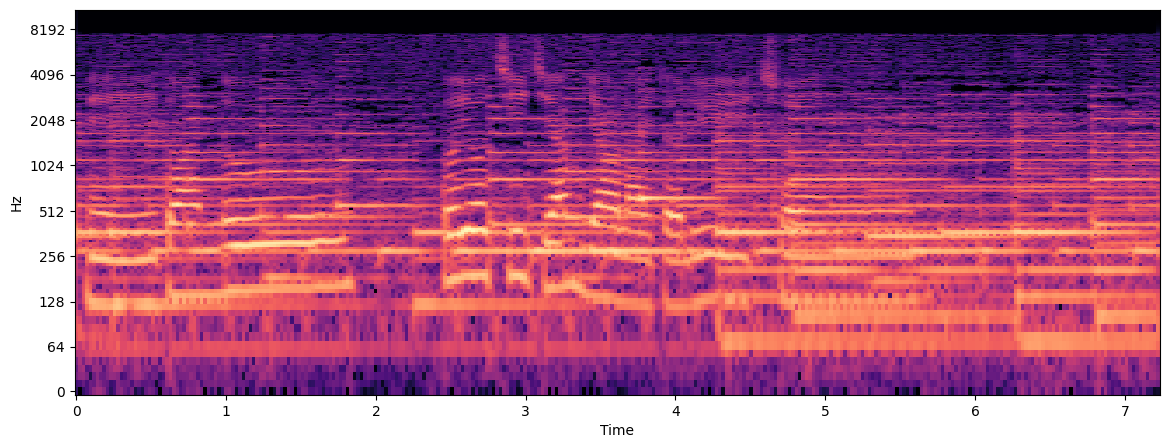

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [1]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from random import choice

# Define el path al directorio de archivos wav
wav_files_path = 'dataset/mir-1k/Wavfile'
wav_files = [f for f in os.listdir(wav_files_path) if f.endswith('.wav')]
selected_file = choice(wav_files)
file_path = os.path.join(wav_files_path, selected_file)

# Carga el archivo de audio seleccionado
y, sr = librosa.load(file_path)

# Genera el espectrograma de la señal
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

# Muestra el espectrograma
plt.figure(figsize=(14, 5))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Espectrograma de: ' + selected_file)
plt.show()


In [2]:
from IPython.display import Audio

# Utiliza el mismo archivo seleccionado para el espectrograma
Audio(file_path)


# Clases y Funciones para Procesamiento de Datos Numéricos 🧮

En este módulo, implementamos una serie de clases y funciones útiles para manipular y procesar datos numéricos, especialmente en el contexto de la ingeniería de características y la preparación de datos para modelos de machine learning.

## Clase `Diff` 🔄

Esta clase se utiliza para calcular la diferencia porcentual entre dos valores numéricos consecutivos, lo que puede ser útil para detectar cambios significativos en las señales o en los datos de series temporales.

## Funciones de Ayuda 🛠️

- `shape`: Obtiene la forma de un tensor como una tupla.
- `pretty_list`: Devuelve una representación en forma de cadena de una lista, separada por comas.
- `pretty_dict`: Devuelve una representación en forma de cadena de un diccionario, con cada par clave-valor en una nueva línea.
- `closest_power_of_two`: Encuentra la potencia de dos más cercana a un número dado.
- `nd_array_to_txt`: Escribe un array de N dimensiones a un archivo de texto, útil para la persistencia de datos y la inspección humana.

Estas herramientas son esenciales para el preprocesamiento de datos y la ingeniería de características en proyectos de deep learning y machine learning.


In [3]:
from __future__ import division  # Garantiza que la división entre enteros produzca un float en Python 2.x

import numpy as np

class Diff(object):
    # Clase para calcular la diferencia porcentual entre dos números
    def __init__(self, v=0.0):
        self.value = v  # valor inicial
        self.diff = 0.0  # diferencia inicial

    def update(self, v):
        # Actualiza el valor y calcula la nueva diferencia porcentual
        if self.value:
            diff = v / self.value - 1
            self.diff = diff
        self.value = v  # Actualiza el valor con el nuevo valor pasado

def shape(tensor):
    # Devuelve la forma del tensor como una tupla
    s = tensor.get_shape()
    return tuple([s[i].value for i in range(0, len(s))])

def pretty_list(list):
    # Devuelve una cadena de texto con los elementos de la lista separados por comas
    return ", ".join(list)

def pretty_dict(dict):
    # Devuelve una cadena de texto con los pares clave-valor del diccionario
    return "\n".join("{} : {}".format(k, v) for k, v in dict.items())

def closest_power_of_two(target):
    # Encuentra la potencia de dos más cercana a un número dado
    if target > 1:
        for i in range(1, int(target)):
            if 2**i >= target:
                pwr = 2**i
                break
        # Devuelve la potencia de dos más cercana o su mitad, dependiendo de cuál esté más cerca
        return pwr if abs(pwr - target) < abs(pwr / 2 - target) else int(pwr / 2)
    else:
        return 1

# Escribe un array de numpy a un archivo de texto
def nd_array_to_txt(filename, data):
    path = filename + ".txt"
    # Abre el archivo en modo de escritura
    with open(path, "w") as outfile:
        # Escribe la forma del array en el encabezado para referencia
        outfile.write("# Array shape: {0}\n".format(data.shape))

        for data_slice in data:
            # Escribe cada "rebanada" del array en el archivo
            np.savetxt(outfile, data_slice, fmt="%-7.2f")
            # Indica el fin de una rebanada
            outfile.write("# New slice\n")


### Configuración

In [5]:
import tensorflow as tf

class ModelConfig:
    SR = 16000  # Sample Rate
    L_FRAME = 1024  # default 1024
    L_HOP = closest_power_of_two(L_FRAME / 4)
    SEQ_LEN = 4
    # For Melspectogram
    N_MELS = 512
    F_MIN = 0.0


# Train
class TrainConfig:
    CASE = str(ModelConfig.SEQ_LEN) + "frames_ikala"
    CKPT_PATH = "checkpoints/" + CASE
    GRAPH_PATH = "graphs/" + CASE + "/train"
    DATA_PATH = "dataset/train/ikala"
    LR = 0.0001
    FINAL_STEP = 100000
    CKPT_STEP = 500
    NUM_WAVFILE = 1
    SECONDS = 8.192  # To get 512,512 in melspecto
    RE_TRAIN = True
    session_conf = tf.compat.v1.ConfigProto(
        device_count={"CPU": 1, "GPU": 1},
        gpu_options=tf.compat.v1.GPUOptions(
            allow_growth=True, per_process_gpu_memory_fraction=0.25
        ),
    )



class EvalConfig:
    # CASE = '1frame'
    # CASE = '4-frames-masking-layer'
    CASE = str(ModelConfig.SEQ_LEN) + "frames_ikala"
    CKPT_PATH = "checkpoints/" + CASE
    GRAPH_PATH = "graphs/" + CASE + "/eval"
    DATA_PATH = "dataset/eval/kpop"
    # DATA_PATH = 'dataset/mir-1k/Wavfile'
    # DATA_PATH = 'dataset/ikala'
    GRIFFIN_LIM = False
    GRIFFIN_LIM_ITER = 1000
    NUM_EVAL = 9
    SECONDS = 60
    RE_EVAL = True
    EVAL_METRIC = False
    WRITE_RESULT = True
    RESULT_PATH = "results/" + CASE
    session_conf = tf.compat.v1.ConfigProto(
        device_count={"CPU": 1, "GPU": 1},
        gpu_options=tf.compat.v1.GPUOptions(allow_growth=True),
        log_device_placement=False,
    )


### Modelo

In [14]:
# -*- coding: utf-8 -*-
# !/usr/bin/env python
"""
By Dabi Ahn. andabi412@gmail.com.
https://www.github.com/andabi

Modificaciones por Grupo 5 - Proyecto Final Deep Learning
UVG - 2023
"""

from __future__ import division
import tensorflow as tf
from tensorflow.keras.layers import GRUCell
import os
import numpy as np


class Model:
    def __init__(self, n_rnn_layer=3, hidden_size=256):

        # Input, Output
        self.x_mixed = tf.compat.v1.placeholder(
            tf.float32, shape=(None, None, ModelConfig.L_FRAME // 2 + 1), name="x_mixed"
        )
        self.y_src1 = tf.compat.v1.placeholder(
            tf.float32, shape=(None, None, ModelConfig.L_FRAME // 2 + 1), name="y_src1"
        )
        self.y_src2 = tf.compat.v1.placeholder(
            tf.float32, shape=(None, None, ModelConfig.L_FRAME // 2 + 1), name="y_src2"
        )

        # Network
        self.hidden_size = hidden_size
        self.n_layer = n_rnn_layer
        self.net = tf.make_template("net", self._net)
        self()

    def __call__(self):
        return self.net()

    def _net(self):
        # RNN and dense layers
        rnn_layer = tf.compat.v1.nn.rnn_cell.MultiRNNCell(
            [GRUCell(self.hidden_size) for _ in range(self.n_layer)]
        )
        output_rnn, rnn_state = tf.nn.dynamic_rnn(
            rnn_layer, self.x_mixed, dtype=tf.float32
        )
        input_size = shape(self.x_mixed)[2]
        y_hat_src1 = tf.layers.dense(
            inputs=output_rnn,
            units=input_size,
            activation=tf.nn.relu,
            name="y_hat_src1",
        )
        y_hat_src2 = tf.layers.dense(
            inputs=output_rnn,
            units=input_size,
            activation=tf.nn.relu,
            name="y_hat_src2",
        )

        # time-freq masking layer
        y_tilde_src1 = (
            y_hat_src1 / (y_hat_src1 + y_hat_src2 + np.finfo(float).eps) * self.x_mixed
        )
        y_tilde_src2 = (
            y_hat_src2 / (y_hat_src1 + y_hat_src2 + np.finfo(float).eps) * self.x_mixed
        )

        return y_tilde_src1, y_tilde_src2

    def loss(self):
        pred_y_src1, pred_y_src2 = self()
        return tf.reduce_mean(
            tf.square(self.y_src1 - pred_y_src1) + tf.square(self.y_src2 - pred_y_src2),
            name="loss",
        )

    @staticmethod
    # shape = (batch_size, n_freq, n_frames) => (batch_size, n_frames, n_freq)
    def spec_to_batch(src):
        num_wavs, freq, n_frames = src.shape

        # Padding
        pad_len = 0
        if n_frames % ModelConfig.SEQ_LEN > 0:
            pad_len = ModelConfig.SEQ_LEN - (n_frames % ModelConfig.SEQ_LEN)
        pad_width = ((0, 0), (0, 0), (0, pad_len))
        padded_src = np.pad(
            src, pad_width=pad_width, mode="constant", constant_values=0
        )

        assert padded_src.shape[-1] % ModelConfig.SEQ_LEN == 0

        batch = np.reshape(
            padded_src.transpose(0, 2, 1), (-1, ModelConfig.SEQ_LEN, freq)
        )
        return batch, padded_src

    @staticmethod
    def batch_to_spec(src, num_wav):
        # shape = (batch_size, n_frames, n_freq) => (batch_size, n_freq, n_frames)
        batch_size, seq_len, freq = src.shape
        src = np.reshape(src, (num_wav, -1, freq))
        src = src.transpose(0, 2, 1)
        return src

    @staticmethod
    def load_state(sess, ckpt_path):
        ckpt = tf.train.get_checkpoint_state(os.path.dirname(ckpt_path + "/checkpoint"))
        if ckpt and ckpt.model_checkpoint_path:
            tf.train.Saver().restore(sess, ckpt.model_checkpoint_path)


### Preprocesamiento

In [11]:
import librosa
import numpy as np
import soundfile as sf

# Batch considered
def get_random_wav(filenames, sec, sr=ModelConfig.SR):
    # load wav -> pad if necessary to fit sr*sec -> get random samples with len = sr*sec -> map = do this for all in filenames -> put in np.array
    src1_src2 = np.array(
        list(
            map(
                lambda f: _sample_range(
                    _pad_wav(librosa.load(f, sr=sr, mono=False)[0], sr, sec), sr, sec
                ),
                filenames,
            )
        )
    )
    mixed = np.array(list(map(lambda f: librosa.to_mono(f), src1_src2)))
    src1, src2 = src1_src2[:, 0], src1_src2[:, 1]
    return mixed, src1, src2


# Batch considered
def to_spectrogram(wav, len_frame=ModelConfig.L_FRAME, len_hop=ModelConfig.L_HOP):
    return np.array(
        list(map(lambda w: librosa.stft(w, n_fft=len_frame, hop_length=len_hop), wav))
    )


# Batch considered
def to_wav(mag, phase, len_hop=ModelConfig.L_HOP):
    stft_matrix = get_stft_matrix(mag, phase)
    return np.array(
        list(map(lambda s: librosa.istft(s, hop_length=len_hop), stft_matrix))
    )


# Batch considered
def to_wav_from_spec(stft_maxrix, len_hop=ModelConfig.L_HOP):
    return np.array(
        list(map(lambda s: librosa.istft(s, hop_length=len_hop), stft_maxrix))
    )


# Batch considered
def to_wav_mag_only(
    mag,
    init_phase,
    len_frame=ModelConfig.L_FRAME,
    len_hop=ModelConfig.L_HOP,
    num_iters=50,
):
    # return np.array(list(map(lambda m_p: griffin_lim(m, len_frame, len_hop, num_iters=num_iters, phase_angle=p)[0], list(zip(mag, init_phase))[1])))
    return np.array(
        list(
            map(
                lambda m: lambda p: griffin_lim(
                    m, len_frame, len_hop, num_iters=num_iters, phase_angle=p
                ),
                list(zip(mag, init_phase))[1],
            )
        )
    )


# Batch considered
def get_magnitude(stft_matrixes):
    return np.abs(stft_matrixes)


# Batch considered
def get_phase(stft_maxtrixes):
    return np.angle(stft_maxtrixes)


# Batch considered
def get_stft_matrix(magnitudes, phases):
    return magnitudes * np.exp(1.0j * phases)


# Batch considered
def soft_time_freq_mask(target_src, remaining_src):
    mask = np.abs(target_src) / (
        np.abs(target_src) + np.abs(remaining_src) + np.finfo(float).eps
    )
    return mask


# Batch considered
def hard_time_freq_mask(target_src, remaining_src):
    mask = np.where(target_src > remaining_src, 1.0, 0.0)
    return mask


def write_wav(data, path, sr=ModelConfig.SR, format="wav", subtype="PCM_16"):
    sf.write("{}.wav".format(path), data, sr, format=format, subtype=subtype)


def griffin_lim(mag, len_frame, len_hop, num_iters, phase_angle=None, length=None):
    assert num_iters > 0
    if phase_angle is None:
        phase_angle = np.pi * np.random.rand(*mag.shape)
    spec = get_stft_matrix(mag, phase_angle)
    for i in range(num_iters):
        wav = librosa.istft(
            spec, win_length=len_frame, hop_length=len_hop, length=length
        )
        if i != num_iters - 1:
            spec = librosa.stft(
                wav, n_fft=len_frame, win_length=len_frame, hop_length=len_hop
            )
            _, phase = librosa.magphase(spec)
            phase_angle = np.angle(phase)
            spec = get_stft_matrix(mag, phase_angle)
    return wav


def _pad_wav(wav, sr, duration):
    assert wav.ndim <= 2

    n_samples = int(sr * duration)
    pad_len = np.maximum(0, n_samples - wav.shape[-1])
    if wav.ndim == 1:
        pad_width = (0, pad_len)
    else:
        pad_width = ((0, 0), (0, pad_len))
    wav = np.pad(wav, pad_width=pad_width, mode="constant", constant_values=0)

    return wav


def _sample_range(wav, sr, duration):
    assert wav.ndim <= 2

    target_len = int(sr * duration)
    wav_len = wav.shape[-1]
    start = np.random.choice(range(np.maximum(1, wav_len - target_len)), 1)[0]
    end = start + target_len
    if wav.ndim == 1:
        wav = wav[start:end]
    else:
        wav = wav[:, start:end]
    return wav


### Data

In [12]:
import random
from os import walk

class Data:
    def __init__(self, path):
        self.path = path

    def next_wavs(self, sec, size=1):
        wavfiles = []
        for (root, dirs, files) in walk(self.path):
            wavfiles.extend(
                ["{}/{}".format(root, f) for f in files if f.endswith(".wav")]
            )
        wavfiles = random.sample(wavfiles, size)
        mixed, src1, src2 = get_random_wav(wavfiles, sec, ModelConfig.SR)
        return mixed, src1, src2, wavfiles


### Entrenamiento

In [15]:

import tensorflow as tf


import os
import shutil
import matplotlib as plt
import librosa.display


def train():
    # Model
    model = Model()

    # Loss, Optimizer
    global_step = tf.Variable(
        0, dtype=tf.int32, trainable=False, name="global_step")
    loss_fn = model.loss()
    optimizer = tf.train.AdamOptimizer(learning_rate=TrainConfig.LR).minimize(
        loss_fn, global_step=global_step
    )

    # Summaries
    summary_op = summaries(model, loss_fn)

    with tf.Session(config=TrainConfig.session_conf) as sess:

        # Initialized, Load state
        sess.run(tf.global_variables_initializer())
        model.load_state(sess, TrainConfig.CKPT_PATH)

        writer = tf.summary.FileWriter(TrainConfig.GRAPH_PATH, sess.graph)

        # Input source
        data = Data(TrainConfig.DATA_PATH)

        loss = Diff()
        for step in range(
            global_step.eval(), TrainConfig.FINAL_STEP
        ):  # changed xrange to range for py3
            mixed_wav, src1_wav, src2_wav, _ = data.next_wavs(
                TrainConfig.SECONDS, TrainConfig.NUM_WAVFILE
            )

            mixed_spec = to_spectrogram(mixed_wav)
            mixed_mag = get_magnitude(mixed_spec)

            src1_spec, src2_spec = to_spectrogram(
                src1_wav), to_spectrogram(src2_wav)
            src1_mag, src2_mag = get_magnitude(
                src1_spec), get_magnitude(src2_spec)

            src1_batch, _ = model.spec_to_batch(src1_mag)
            src2_batch, _ = model.spec_to_batch(src2_mag)
            mixed_batch, _ = model.spec_to_batch(mixed_mag)

            l, _, summary = sess.run(
                [loss_fn, optimizer, summary_op],
                feed_dict={
                    model.x_mixed: mixed_batch,
                    model.y_src1: src1_batch,
                    model.y_src2: src2_batch,
                },
            )

            loss.update(l)
            print(
                "step-{}\td_loss={:2.2f}\tloss={}".format(
                    step, loss.diff * 100, loss.value
                )
            )

            writer.add_summary(summary, global_step=step)

            # Save state
            if step % TrainConfig.CKPT_STEP == 0:
                tf.train.Saver().save(
                    sess, TrainConfig.CKPT_PATH + "/checkpoint", global_step=step
                )

        writer.close()


def summaries(model, loss):
    for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES):
        tf.summary.histogram(v.name, v)
        tf.summary.histogram("grad/" + v.name, tf.gradients(loss, v))
    tf.summary.scalar("loss", loss)
    tf.summary.histogram("x_mixed", model.x_mixed)
    tf.summary.histogram("y_src1", model.y_src1)
    tf.summary.histogram("y_src2", model.y_src1)
    return tf.summary.merge_all()


def setup_path():
    if TrainConfig.RE_TRAIN:
        if os.path.exists(TrainConfig.CKPT_PATH):
            shutil.rmtree(TrainConfig.CKPT_PATH)
        if os.path.exists(TrainConfig.GRAPH_PATH):
            shutil.rmtree(TrainConfig.GRAPH_PATH)
    if not os.path.exists(TrainConfig.CKPT_PATH):
        os.makedirs(TrainConfig.CKPT_PATH)


if __name__ == "__main__":
    setup_path()
    train()


RuntimeError: tf.placeholder() is not compatible with eager execution.

### Evaluación

In [ ]:
import os
import shutil
import numpy as np
import tensorflow as tf
from mir_eval.separation import bss_eval_sources



def eval():
    # Model
    model = Model()
    global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name="global_step")

    with tf.Session(config=EvalConfig.session_conf) as sess:

        # Initialized, Load state
        sess.run(tf.global_variables_initializer())
        model.load_state(sess, EvalConfig.CKPT_PATH)

        writer = tf.summary.FileWriter(EvalConfig.GRAPH_PATH, sess.graph)

        data = Data(EvalConfig.DATA_PATH)
        mixed_wav, src1_wav, src2_wav, wavfiles = data.next_wavs(
            EvalConfig.SECONDS, EvalConfig.NUM_EVAL
        )

        mixed_spec = to_spectrogram(mixed_wav)
        mixed_mag = get_magnitude(mixed_spec)
        mixed_batch, padded_mixed_mag = model.spec_to_batch(mixed_mag)
        mixed_phase = get_phase(mixed_spec)

        assert np.all(
            np.equal(
                model.batch_to_spec(mixed_batch, EvalConfig.NUM_EVAL), padded_mixed_mag
            )
        )

        (pred_src1_mag, pred_src2_mag) = sess.run(
            model(), feed_dict={model.x_mixed: mixed_batch}
        )

        seq_len = mixed_phase.shape[-1]
        pred_src1_mag = model.batch_to_spec(pred_src1_mag, EvalConfig.NUM_EVAL)[
            :, :, :seq_len
        ]
        pred_src2_mag = model.batch_to_spec(pred_src2_mag, EvalConfig.NUM_EVAL)[
            :, :, :seq_len
        ]

        # Time-frequency masking
        mask_src1 = soft_time_freq_mask(pred_src1_mag, pred_src2_mag)
        # mask_src1 = hard_time_freq_mask(pred_src1_mag, pred_src2_mag)
        mask_src2 = 1.0 - mask_src1
        pred_src1_mag = mixed_mag * mask_src1
        pred_src2_mag = mixed_mag * mask_src2

        # (magnitude, phase) -> spectrogram -> wav
        if EvalConfig.GRIFFIN_LIM:
            pred_src1_wav = to_wav_mag_only(
                pred_src1_mag,
                init_phase=mixed_phase,
                num_iters=EvalConfig.GRIFFIN_LIM_ITER,
            )
            pred_src2_wav = to_wav_mag_only(
                pred_src2_mag,
                init_phase=mixed_phase,
                num_iters=EvalConfig.GRIFFIN_LIM_ITER,
            )
        else:
            pred_src1_wav = to_wav(pred_src1_mag, mixed_phase)
            pred_src2_wav = to_wav(pred_src2_mag, mixed_phase)

        # Write the result
        tf.summary.audio(
            "GT_mixed", mixed_wav, ModelConfig.SR, max_outputs=EvalConfig.NUM_EVAL
        )
        tf.summary.audio(
            "Pred_music", pred_src1_wav, ModelConfig.SR, max_outputs=EvalConfig.NUM_EVAL
        )
        tf.summary.audio(
            "Pred_vocal", pred_src2_wav, ModelConfig.SR, max_outputs=EvalConfig.NUM_EVAL
        )

        if EvalConfig.EVAL_METRIC:
            # Compute BSS metrics
            gnsdr, gsir, gsar = bss_eval_global(
                mixed_wav, src1_wav, src2_wav, pred_src1_wav, pred_src2_wav
            )

            # Write the score of BSS metrics
            tf.summary.scalar("GNSDR_music", gnsdr[0])
            tf.summary.scalar("GSIR_music", gsir[0])
            tf.summary.scalar("GSAR_music", gsar[0])
            tf.summary.scalar("GNSDR_vocal", gnsdr[1])
            tf.summary.scalar("GSIR_vocal", gsir[1])
            tf.summary.scalar("GSAR_vocal", gsar[1])

        if EvalConfig.WRITE_RESULT:
            # Write the result
            for i in range(len(wavfiles)):
                name = wavfiles[i].replace("/", "-").replace(".wav", "")
                write_wav(
                    mixed_wav[i],
                    "{}/{}-{}".format(EvalConfig.RESULT_PATH, name, "original"),
                )
                write_wav(
                    pred_src1_wav[i],
                    "{}/{}-{}".format(EvalConfig.RESULT_PATH, name, "music"),
                )
                write_wav(
                    pred_src2_wav[i],
                    "{}/{}-{}".format(EvalConfig.RESULT_PATH, name, "voice"),
                )

        writer.add_summary(
            sess.run(tf.summary.merge_all()), global_step=global_step.eval()
        )

        writer.close()


def bss_eval_global(mixed_wav, src1_wav, src2_wav, pred_src1_wav, pred_src2_wav):
    len_cropped = pred_src1_wav.shape[-1]
    src1_wav = src1_wav[:, :len_cropped]
    src2_wav = src2_wav[:, :len_cropped]
    mixed_wav = mixed_wav[:, :len_cropped]
    gnsdr = gsir = gsar = np.zeros(2)
    total_len = 0
    for i in range(EvalConfig.NUM_EVAL):
        sdr, sir, sar, _ = bss_eval_sources(
            np.array([src1_wav[i], src2_wav[i]]),
            np.array([pred_src1_wav[i], pred_src2_wav[i]]),
            False,
        )
        sdr_mixed, _, _, _ = bss_eval_sources(
            np.array([src1_wav[i], src2_wav[i]]),
            np.array([mixed_wav[i], mixed_wav[i]]),
            False,
        )
        nsdr = sdr - sdr_mixed
        gnsdr += len_cropped * nsdr
        gsir += len_cropped * sir
        gsar += len_cropped * sar
        total_len += len_cropped
    gnsdr = gnsdr / total_len
    gsir = gsir / total_len
    gsar = gsar / total_len
    return gnsdr, gsir, gsar


def setup_path():
    if EvalConfig.RE_EVAL:
        if os.path.exists(EvalConfig.GRAPH_PATH):
            shutil.rmtree(EvalConfig.GRAPH_PATH)
        if os.path.exists(EvalConfig.RESULT_PATH):
            shutil.rmtree(EvalConfig.RESULT_PATH)

    if not os.path.exists(EvalConfig.RESULT_PATH):
        os.makedirs(EvalConfig.RESULT_PATH)


if __name__ == "__main__":
    setup_path()
    eval()
